In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
# read the text file
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
# hyperparameters
seed = 2147483647
block_size = 3 # context length
embedding_dim = 2
hidden_layer_size = 100
alphabet_size = len(itos)
learning_rate = 0.1
mini_batch_size = 32

In [8]:
# build the dataset
x, y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        x.append(context)
        y.append(ix)
        # print(''.join([itos[i] for i in context]), '--->', itos[ix])
        context = context[1:] + [ix] # slide the context

x = torch.tensor(x)
y = torch.tensor(y)
x.shape, y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [9]:
# parameters
def reset_parameters():
    g = torch.Generator().manual_seed(seed)
    C = torch.randn((alphabet_size, embedding_dim), generator=g)
    # first layer
    W1 = torch.randn((block_size * embedding_dim, hidden_layer_size), generator=g)
    b1 = torch.randn((hidden_layer_size), generator=g)
    # second layer
    W2 = torch.randn((hidden_layer_size, alphabet_size), generator=g)
    b2 = torch.randn((alphabet_size), generator=g)
    return C, W1, b1, W2, b2

C, W1, b1, W2, b2 = reset_parameters()
parameters = [C, W1, b1, W2, b2]

In [10]:
# number of parameters
sum(p.numel() for p in parameters)

3481

In [11]:
for p in parameters:
    p.requires_grad_()

In [406]:
for i in range(10):
    # forward pass
    emb = C[x] # (32, 3 , 2)
    h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(dim=1, keepdim=True)
    # loss = -prob[torch.arange(5), y].log().mean()
    loss = F.cross_entropy(logits, y)
    print(f'{i}th iteration loss: {loss.item()}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update the parameters
    for p in parameters:
        p.data -= learning_rate * p.grad


0th iteration loss: 19.505229949951172
1th iteration loss: 17.084491729736328
2th iteration loss: 15.776532173156738
3th iteration loss: 14.833338737487793
4th iteration loss: 14.002596855163574
5th iteration loss: 13.253254890441895
6th iteration loss: 12.579914093017578
7th iteration loss: 11.983097076416016
8th iteration loss: 11.470491409301758
9th iteration loss: 11.05185604095459


In [407]:
training_iterations = 1000
lri = []
lossi = []

lre = torch.linspace(-3, 0, training_iterations)
lrs = 10**lre

# use mini batches
for i in range(training_iterations):
    ix = torch.randint(0, x.shape[0], (mini_batch_size,))

    # forward pass
    emb = C[x[ix]]
    h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y[ix])
    if i % (training_iterations/10) == 0:
        print(f'{i}th iteration loss: {loss.item()}, learning rate: {lrs[i]}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # keep track of loss and lr
    lri.append(lre[i])
    lossi.append(loss.item())

    # update the parameters
    for p in parameters:
        p.data -= lrs[i] * p.grad

0th iteration loss: 10.426352500915527, learning rate: 0.0010000000474974513
100th iteration loss: 11.404221534729004, learning rate: 0.001996642677113414
200th iteration loss: 7.499330997467041, learning rate: 0.003986582159996033
300th iteration loss: 7.412033557891846, learning rate: 0.007959775626659393
400th iteration loss: 7.594030380249023, learning rate: 0.01589282788336277
500th iteration loss: 5.07920503616333, learning rate: 0.03173229098320007
600th iteration loss: 2.9455490112304688, learning rate: 0.06335804611444473
700th iteration loss: 2.717862129211426, learning rate: 0.1265033781528473
800th iteration loss: 3.491755247116089, learning rate: 0.25258201360702515
900th iteration loss: 6.334482669830322, learning rate: 0.504315972328186


In [408]:
emb = C[x] 
h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y)
loss

tensor(7.8875, grad_fn=<NllLossBackward0>)

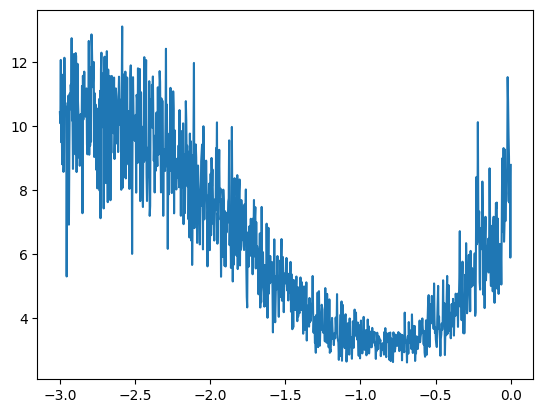

In [409]:
# plot the learning rate / loss curve
plt.plot(lri, lossi) # 0.1 looks like a good learning rate

In [410]:
training_iterations = 20000
learning_rate = 0.5

# use mini batches
for i in range(training_iterations):
    ix = torch.randint(0, x.shape[0], (mini_batch_size,))

    # forward pass
    emb = C[x[ix]]
    h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y[ix])
    if i % (training_iterations/10) == 0:
        print(f'{i}th iteration loss: {loss.item()}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr decay
    if i % (training_iterations/4) == 0:
        learning_rate /= 5

    # update the parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

emb = C[x] 
h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y)
loss

0th iteration loss: 9.557682037353516
2000th iteration loss: 2.508436441421509
4000th iteration loss: 2.514707326889038
6000th iteration loss: 2.353314161300659
8000th iteration loss: 2.5112898349761963
10000th iteration loss: 2.5420806407928467
12000th iteration loss: 2.222245931625366
14000th iteration loss: 2.4578216075897217
16000th iteration loss: 2.408839702606201
18000th iteration loss: 2.476323366165161


tensor(2.3926, grad_fn=<NllLossBackward0>)

In [13]:
# let's split the dataset into training, validation and test sets
def build_dataset(words):
    block_size = 3
    x, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix] # slide the context

    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [19]:
# let's train a bigger model
embedding_dim = 10
hidden_layer_size = 300

C, W1, b1, W2, b2 = reset_parameters()
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad_()

stepi = []
lossi = []

training_iterations = 100000
learning_rate = 0.5

for i in range(training_iterations):

    # mini batch contruct
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    if i % (training_iterations/10) == 0:
        print(f'{i}th iteration loss: {loss.item()}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr decay
    if i % (training_iterations/4) == 0:
        learning_rate /= 5

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

    # update the parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

0th iteration loss: 32.0539665222168
10000th iteration loss: 2.2922236919403076
20000th iteration loss: 2.8701987266540527
30000th iteration loss: 2.657052993774414
40000th iteration loss: 2.6812124252319336
50000th iteration loss: 2.3045685291290283
60000th iteration loss: 2.0472702980041504
70000th iteration loss: 2.200258255004883
80000th iteration loss: 2.189608097076416
90000th iteration loss: 2.2814347743988037


In [20]:
# validation loss
emb = C[Xdev] 
h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2330, grad_fn=<NllLossBackward0>)

In [21]:
# training loss
emb = C[Xtr] 
h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1972, grad_fn=<NllLossBackward0>)

at this point we're starting to see some overfitting

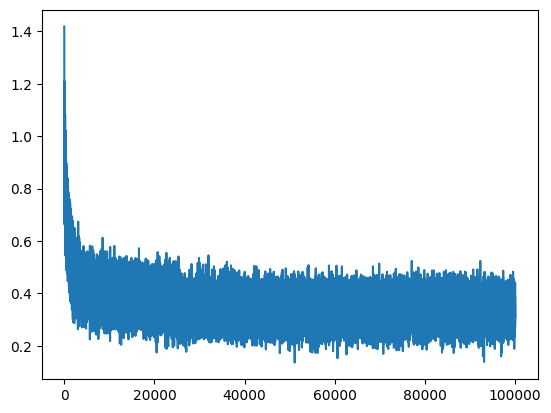

In [454]:
# plot the loss
plt.plot(stepi, lossi)

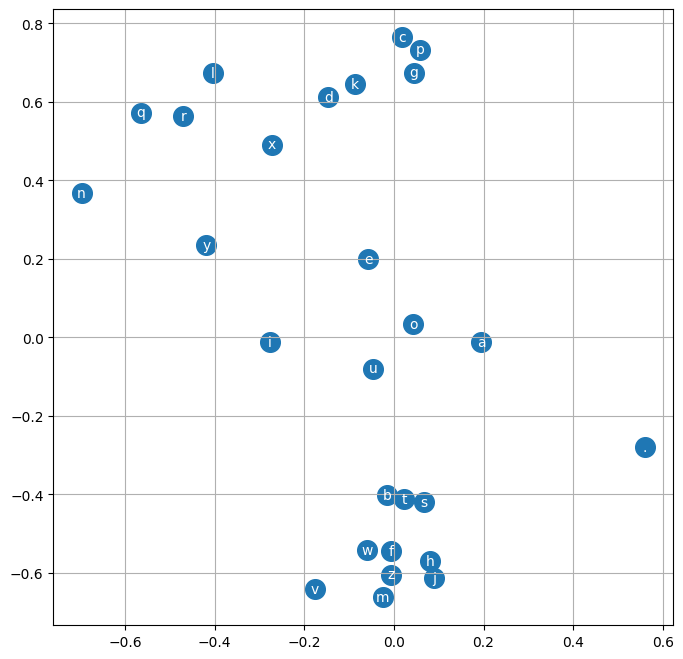

In [444]:
# visualise the embeddings (works only if embedding_dim == 2)
def visualise_embeddings():
    plt.figure(figsize=(8, 8))
    plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
    for i in range(C.shape[0]):
        plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
    plt.grid('minor')
# visualise_embeddings()

In [22]:
# sample from the model
seed = 2147483647
g = torch.Generator().manual_seed(seed)

# sample 20 names
ix = 0
for _ in range(20):
    out = ''
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]

        if ix == 0:
            break
        out += itos[ix]
        
    print(out)

cerie
zomalurailezity
kell
imitta
nella
kamanda
samiyah
javer
gotot
molie
cavo
kented
jen
emva
sade
enkamirry
foba
mhikingavtahlyn
kasdro
anell
